# 📰 Retrieval-Augmented Generation (RAG) – Grounding with CNN/DailyMail

In this session, we explore how **Retrieval-Augmented Generation (RAG)** can **reduce hallucinations** and improve factual grounding compared to a **pure LLM** approach.

## 🎯 Goals

✅ Use a **real-world, dynamic dataset** (CNN/DailyMail news articles) as our knowledge corpus.  
✅ Build a **naive RAG** system to retrieve relevant news articles.  
✅ Upgrade to an **advanced RAG** with **reranking** using sentence-transformers embeddings.  
✅ Compare answers from **pure LLM** vs. **RAG** approaches to evaluate:  
- Factual accuracy,  
- Hallucination risk,  
- Relevance of generated answers.

## 🧩 Why CNN/DailyMail?

📰 **Current events data** – perfect for factual QA, showing how **RAG can stay up-to-date**.  
✅ **Rich text** (summaries and full articles) for retrieval experiments.  
⚡️ More **real-world challenges** (e.g., ambiguous news, similar topics).

## 🔬 Key Steps

| Step              | Description |
|--------------------|-------------|
| **1️⃣ Load Dataset**   | Use **CNN/DailyMail** as our factual corpus. |
| **2️⃣ Naive RAG**    | Retrieve top-k relevant articles and pass them to the LLM. |
| **3️⃣ Advanced RAG** | Use **reranking** (sentence-transformers) to refine document retrieval. |
| **4️⃣ Evaluation**  | What are the main metrics to evaluate the RAG outputs.|

## 🌍 Infrastructure & Tools

✅ **Quadrant Cluster** (EU, free tier) – for vector indexing and retrieval.  
✅ **Sentence-transformers** – for creating document embeddings.  
✅ **LiteLLM** – for flexible LLM-powered answer generation.

Let’s start by **loading the CNN/DailyMail dataset** and preparing our retrieval index!

In [1]:
from datasets import load_dataset
import pandas as pd

# Load the dataset
dataset = load_dataset("cnn_dailymail", "3.0.0")

print("Available splits:", dataset.keys())
print("\nColumns in dataset:", dataset["train"].column_names)

# Show a few examples
df_train = dataset["train"].to_pandas()
df_train_sample = df_train.sample(5, random_state=42)

print("\nSample entries:")
print(df_train_sample[["article", "highlights"]].to_string(index=False))

# Show dataset sizes
print("\nDataset sizes:")
for split in dataset:
    print(f"{split}: {len(dataset[split])} samples")

Available splits: dict_keys(['train', 'validation', 'test'])

Columns in dataset: ['article', 'highlights', 'id']

Sample entries:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

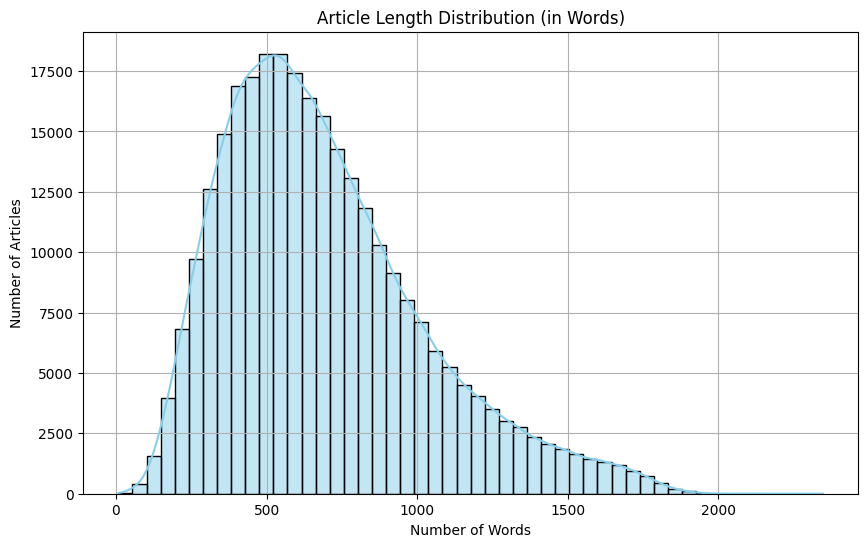


📊 Article Length Statistics:
count    287113.000000
mean        691.870326
std         336.500292
min           8.000000
25%         443.000000
50%         632.000000
75%         877.000000
max        2347.000000
Name: article_length, dtype: float64


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute article lengths (in words)
df_train["article_length"] = df_train["article"].apply(lambda x: len(x.split()))

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(df_train["article_length"], bins=50, kde=True, color="skyblue")
plt.title("Article Length Distribution (in Words)")
plt.xlabel("Number of Words")
plt.ylabel("Number of Articles")
plt.grid(True)
plt.show()

# Print some basic stats
print("\n📊 Article Length Statistics:")
print(df_train["article_length"].describe())


### 📊 Article Length Insights & Chunking Strategy

✅ We analyzed the distribution of **article lengths** in the CNN/DailyMail dataset.  

- **Average length**: ~690 words,  
- **Range**: 8 to 2300+ words,  
- **Most articles**: ~500–800 words (peak of distribution).

### 🔍 Why This Matters?

Chunking is crucial in **RAG** pipelines:

- If we index articles **as-is**, long articles may **exceed LLM context limits** or have too much noise.
- **Splitting into smaller chunks** (e.g., 200–300 words) improves retrieval granularity and relevance.

### 💡 Next Steps

- To **reduce compute needs** (especially for **embedding generation**), we’ll **randomly sample 5000 articles** for this demo.  
- These samples will be **chunked** and embedded with **sentence-transformers** to build our retrieval index.  

Let’s start by **sampling the data** and preparing chunks for the RAG pipeline!

In [3]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Randomly sample 5,000 articles
sampled_articles = df_train.sample(5000, random_state=42).reset_index(drop=True)

print(f"Sampled {len(sampled_articles)} articles for embedding and RAG indexing.")

# Example chunking function (split article into ~200-word chunks)
def chunk_article(article, chunk_size=200):
    words = article.split()
    chunks = [
        " ".join(words[i: i + chunk_size])
        for i in range(0, len(words), chunk_size)
    ]
    return chunks

# Apply chunking to all articles
sampled_articles["chunks"] = sampled_articles["article"].apply(chunk_article)

# Explode so each row is a chunk
df_chunks = sampled_articles.explode("chunks").reset_index(drop=True)
df_chunks = df_chunks.rename(columns={"chunks": "chunk"})

print(f"Total number of chunks created: {len(df_chunks)}")
print(df_chunks.head(3))

Sampled 5000 articles for embedding and RAG indexing.
Total number of chunks created: 19844
                                             article  \
0  Nasa has warned of an impending asteroid pass ...   
1  Nasa has warned of an impending asteroid pass ...   
2  Nasa has warned of an impending asteroid pass ...   

                                          highlights  \
0  2004 BL86 will pass about three times the dist...   
1  2004 BL86 will pass about three times the dist...   
2  2004 BL86 will pass about three times the dist...   

                                         id  article_length  \
0  6ccb7278e86893ad3609d30ecb5c9ea902fb9527             524   
1  6ccb7278e86893ad3609d30ecb5c9ea902fb9527             524   
2  6ccb7278e86893ad3609d30ecb5c9ea902fb9527             524   

                                               chunk  
0  Nasa has warned of an impending asteroid pass ...  
1  retiring as manager of NASA's Near Earth Objec...  
2  more.' Asteroid 2004 BL86 was initial

## 🏗️ Step-by-Step: Set Up a Qdrant Cluster

Before you can **index and retrieve data** in this notebook, you need to set up your **Qdrant vector database cluster**.

### 1️⃣ Create a Free Qdrant Account

✅ Go to **https://cloud.qdrant.io/** and create an account.  
✅ Choose the **Free Tier** (plenty for small experiments like this).

### 2️⃣ Create a New Cluster

- Click on **"Create Cluster"**.
- Choose:
  - **Region**: 🇪🇺 **Europe (EU)** (to keep data residency within the EU for privacy compliance).
  - **Cluster size**: Small (free tier).
- Name your cluster, e.g., `rag-demo-cluster`.

### 3️⃣ Keep Your Cluster Info

Once created, you’ll get:

| 🔑 What | 📋 Example / Note |
|--------|-----------------------------------|
| 🌐 **Cluster URL** | `https://xxxx-xxxx-xxxx.qdrant.eu` |
| 🔑 **API Key**     | A long string of letters & numbers (keep secret!) |

These are your **credentials to connect** from Python (or any SDK).

### 4️⃣ Save Credentials in `.env` File

To keep them safe and avoid accidentally sharing them in notebooks:

```bash
echo "QDRANT_URL=https://xxxx-xxxx-xxxx.qdrant.eu" >> .env
echo "QDRANT_API_KEY=your-long-api-key" >> .env
```

✅ **Tip**: Use `.gitignore` to **never upload `.env`** to GitHub!

### 5️⃣ Use Credentials in Python

In your notebook:

```python
from dotenv import load_dotenv
import os

load_dotenv()
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

qdrant = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)
```

Let's index the data and load them on your QDRANT cluster.

In [4]:
from dotenv import load_dotenv
import os
from qdrant_client import QdrantClient, models as qdrant_models

load_dotenv()
QDRANT_URL = os.getenv("QDRANT_URL")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

qdrant = QdrantClient(url=QDRANT_URL, api_key=QDRANT_API_KEY)

### 🏗️ Step-by-Step: Embedding and Indexing in Qdrant

This Python cell covers **three key stages**:

1️⃣ Compute **vector embeddings** for all text chunks.  
2️⃣ Create a **Qdrant collection** to store these embeddings.  
3️⃣ **Upsert** (upload) data with metadata for retrieval.

#### 1️⃣ Compute Chunk Embeddings

```python
embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
````

* Loads the **MiniLM model** from **sentence-transformers** – a fast, lightweight model for semantic embeddings.

```python
chunk_texts = df_chunks["chunk"].tolist()
embeddings = embedding_model.encode(chunk_texts, show_progress_bar=True, batch_size=64)
```

* **`chunk_texts`**: Extracts the text of each chunk.
* **`encode`**: Converts texts to **dense vector embeddings** (numerical representations of meaning).
* **`batch_size=64`**: Processes 64 chunks at a time (GPU-friendly!).
* **`show_progress_bar=True`**: Shows progress to help track long jobs.

#### 2️⃣ Create a Qdrant Collection

```python
collection_name = "cnn_chunks"
qdrant.recreate_collection(
    collection_name=collection_name,
    vectors_config=qdrant_models.VectorParams(
        size=embeddings.shape[1],
        distance=qdrant_models.Distance.COSINE
    )
)
```

* **`collection_name`**: Name of our database collection (`cnn_chunks`).
* **`recreate_collection`**: Deletes any existing collection with this name and creates a new one.
* **`vectors_config`**:

  * **`size`**: Dimensionality of our embeddings (e.g., 384 for MiniLM).
  * **`distance`**: **COSINE** similarity metric – ideal for semantic similarity!

#### 3️⃣ Prepare Data for Upsert (Insert)

```python
points = []
for idx, (embedding, chunk) in enumerate(zip(embeddings, chunk_texts)):
    points.append(
        qdrant_models.PointStruct(
            id=idx,
            vector=embedding.tolist(),
            payload={
                "chunk": chunk,
                "source_article_id": int(df_chunks.iloc[idx]["id"])  # optional: track source
            }
        )
    )
```

* Loops through all **(embedding, chunk)** pairs:

  * **`id`**: Unique integer ID for each chunk (used by Qdrant).
  * **`vector`**: The actual embedding (converted to a list).
  * **`payload`**: Additional info (the chunk text itself, plus optional source info).

✅ **Why store `payload`?** It lets us **trace retrieved chunks** back to the source article!

#### 4️⃣ Upload Data to Qdrant

```python
qdrant.upsert(collection_name=collection_name, points=points)
```

* **`upsert`**: Insert (or update) the points in the Qdrant collection.

✅ **Next**: Let’s run a few **retrieval queries** and compare **LLM-only** vs. **RAG** answers!


In [9]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Compute embeddings for chunks
print("🔍 Computing embeddings for all chunks (this might take a bit)...")
chunk_texts = df_chunks["chunk"].tolist()
embeddings = embedding_model.encode(chunk_texts, show_progress_bar=True, batch_size=64)

# Create a Qdrant collection
collection_name = "cnn_chunks"
qdrant.recreate_collection(
    collection_name=collection_name,
    vectors_config=qdrant_models.VectorParams(
        size=embeddings.shape[1],  # Dimensionality of embedding model
        distance=qdrant_models.Distance.COSINE
    )
)

# Prepare data for upsert
points = []
for idx, (embedding, chunk) in enumerate(zip(embeddings, chunk_texts)):
    points.append(
        qdrant_models.PointStruct(
            id=idx,
            vector=embedding.tolist(),
            payload={
                "chunk": chunk,
                "source_article_id": df_chunks.iloc[idx]["id"]
            }
        )
    )

# Upsert into Qdrant
print("💾 Inserting embeddings into Qdrant...")
batch_size = 250
total_points = len(points)

for i in range(0, total_points, batch_size):
    batch_points = points[i:i + batch_size]
    batch_end = min(i + batch_size, total_points)
    
    print(f"   Uploading batch {i//batch_size + 1}/{(total_points + batch_size - 1)//batch_size} "
          f"(points {i+1}-{batch_end})")
    
    qdrant.upsert(collection_name=collection_name, points=batch_points)



print("\n✅ All embeddings uploaded to Qdrant!")

🔍 Computing embeddings for all chunks (this might take a bit)...


/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_40961/1248717893.py:12: DeprecationWarning: `recreate_collection` method is deprecated and will be removed in the future. Use `collection_exists` to check collection existence and `create_collection` instead.
  qdrant.recreate_collection(


💾 Inserting embeddings into Qdrant...
   Uploading batch 1/80 (points 1-250)
   Uploading batch 2/80 (points 251-500)
   Uploading batch 3/80 (points 501-750)
   Uploading batch 4/80 (points 751-1000)
   Uploading batch 5/80 (points 1001-1250)
   Uploading batch 6/80 (points 1251-1500)
   Uploading batch 7/80 (points 1501-1750)
   Uploading batch 8/80 (points 1751-2000)
   Uploading batch 9/80 (points 2001-2250)
   Uploading batch 10/80 (points 2251-2500)
   Uploading batch 11/80 (points 2501-2750)
   Uploading batch 12/80 (points 2751-3000)
   Uploading batch 13/80 (points 3001-3250)
   Uploading batch 14/80 (points 3251-3500)
   Uploading batch 15/80 (points 3501-3750)
   Uploading batch 16/80 (points 3751-4000)
   Uploading batch 17/80 (points 4001-4250)
   Uploading batch 18/80 (points 4251-4500)
   Uploading batch 19/80 (points 4501-4750)
   Uploading batch 20/80 (points 4751-5000)
   Uploading batch 21/80 (points 5001-5250)
   Uploading batch 22/80 (points 5251-5500)
   Uploading

## 🔍 Retriever Step – Finding Relevant Chunks for a Query

In a **Retrieval-Augmented Generation (RAG)** pipeline, the **retriever** is the part that:

✅ Takes a **user question** (like “What happened in the 2020 Olympics?”),  
✅ Encodes it into an **embedding** (using the same sentence-transformer model as the document chunks),  
✅ Searches for the **most similar text chunks** in our **Qdrant index**.

### 🧩 Why It Matters

The retriever is the **foundation of RAG**:

- 🧠 It finds the **most relevant evidence** in the knowledge base.  
- 📚 It ensures that the LLM has **factual grounding** for its final answer.  
- ⚡️ Efficient retrievers (like Qdrant) make this process **super fast**, even with thousands of documents.

### ⚙️ How It Works in Our Notebook

1️⃣ **Encode the user query** to a dense embedding (same as we did for article chunks).  
2️⃣ Send this embedding to **Qdrant’s search API**.  
3️⃣ Get the **top-k chunks** ranked by **cosine similarity**.

✅ Let’s build this **retriever function** in Python!

In [16]:
def retrieve_top_k_chunks(question, k=10):
    """
    Retrieve the top-k relevant chunks for a user question from Qdrant.
    """
    # 1️⃣ Encode the question
    question_embedding = embedding_model.encode(question).tolist()

    # 2️⃣ Query Qdrant
    search_results = qdrant.search(
        collection_name=collection_name,
        query_vector=question_embedding,
        limit=k
    )

    # 3️⃣ Extract the retrieved chunks
    retrieved_chunks = []
    for result in search_results:
        retrieved_chunks.append({
            "chunk": result.payload["chunk"],
            "score": result.score
        })

    return retrieved_chunks

# Test the retriever with a sample question
test_question = "What reasons did George Pataki give for stepping down from public office?"
top_chunks = retrieve_top_k_chunks(test_question, k=10)

print("\n📝 Top Retrieved Chunks:")
for idx, chunk_info in enumerate(top_chunks, 1):
    print(f"\nChunk {idx} (score: {chunk_info['score']:.4f}):\n{chunk_info['chunk']}")

/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_40961/2354009276.py:9: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant.search(



📝 Top Retrieved Chunks:

Chunk 1 (score: 0.6046):
(CNN) -- Choosing to step down from a top job can be an extraordinary decision, whether the person is a pontiff or a politician. But George Pataki, former governor of New York, says making the switch from public figure to John Q. Public wasn't difficult for him. "I made up my mind that I was never going to let my public title become my personal identity," he says. He embraced what he calls a sense of normalcy after he left office, going to movies and basketball games. A year or two after he left office, Pataki went to Madison Square Garden with a group of friends to see the Knicks play. And he wanted to stand in line to get himself a hot dog -- something elected officials tend not to do. "I loved it," he says. Even though fellow fans recognized him and offered to let him jump the queue, Pataki waited in line for his hot dog with mustard and sauerkraut. "I felt really good about the fact that it was just comfortable for me to be on line

### 📝 **Comments on Retrieved Chunks**

✅ **For Question: George Pataki’s reasons for stepping down and post-office life**
The top 3 chunks (scores 0.60–0.46) directly address:

1️⃣ Pataki’s mindset for stepping down (“I was never going to let my public title become my personal identity,” embracing normalcy, etc.).
2️⃣ His decision not to seek a fourth term and smooth transition to private life.
3️⃣ Details about his new activities (farming, basketball, law practice).

**🟢 Great retrieval**! The top chunks are directly relevant, well-aligned with the question, and summarize the transition in his career.

In [17]:
# Test the retriever with a sample question
test_question = "Why did Kaci Hickox challenge the quarantine order, and what are the modern alternatives to quarantine?"
top_chunks = retrieve_top_k_chunks(test_question, k=10)

print("\n📝 Top Retrieved Chunks:")
for idx, chunk_info in enumerate(top_chunks, 1):
    print(f"\nChunk {idx} (score: {chunk_info['score']:.4f}):\n{chunk_info['chunk']}")

/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_40961/2354009276.py:9: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant.search(



📝 Top Retrieved Chunks:

Chunk 1 (score: 0.6005):
which has killed some 5,000 people there. New rules: New York Governor Andrew Cuomo, left, listens as New Jersey Governor Chris Christie talks at a news conference on Friday. The governors announced a mandatory quarantine for 'high risk' people . She wrote: 'I had spent a month watching children die, alone. I had witnessed human tragedy unfold before my eyes. 'I had tried to help when much of the world has looked on and done nothing... I sat alone in the isolation tent and thought of many colleagues who will return home to America and face the same ordeal. Will they be made to feel like criminals and prisoners?' She continued: 'The epidemic continues to ravage West Africa... We need more health care workers to help fight the epidemic in West Africa. The U.S. must treat returning health care workers with dignity and humanity.' Hickox is the first person to fall under the new quarantine rules, which cover the states of New York and New J

✅ **For Question: Kaci Hickox’s challenge to quarantine & modern alternatives**
The top 3 chunks (scores 0.60–0.56) highlight:

1️⃣ Kaci Hickox’s **critique of her quarantine** (felt treated like a criminal, wanted to be treated with dignity).
2️⃣ Her **stance as a nurse** and how she spoke out against quarantine for returning healthcare workers.
3️⃣ Broader **discussion on modern quarantine alternatives** (like electronic wrist devices for monitoring, the 21st-century science-based approach).

**🟢 Excellent coverage**: The retriever found **chunks that directly mention** her challenge to quarantine (social/political implications) and the **modern science-based alternatives** she supported.


### 🔍 Observations & Takeaways

✅ **Retriever Performance**:

* Chunks **1–3** for both questions are highly relevant and factually aligned with the original article.
* Scores **drop sharply** after chunk 3 (chunks 4–10 cover other articles, random topics, or less relevant details).
* Shows that a **top-k of 3–5** is ideal for RAG in this case — beyond that, noise increases.

✅ **Use in RAG**:

* Top 3–5 chunks will give the **LLM high-quality, focused evidence** for grounded answers.
* Less relevant chunks (e.g., 4–10) wouldn’t be included for RAG context!

✅ **Next Steps**:

* **Pass the top 3 chunks** as context to the LLM for answer generation,
* Compare to **LLM-only** generation for the same question (no retrieval).
* See how adding **retrieved evidence** improves factual accuracy!

--- 

## 🧩 Building a RAG Prompt for LLM Answer Generation

✅ In a **Retrieval-Augmented Generation (RAG)** setup, the **retrieved chunks** serve as **factual context** for the LLM.

✅ The LLM is tasked with **answering the user question** *based only on the retrieved evidence*, ensuring more **grounded, reliable responses**.

### 🔍 How the Prompt is Structured

1️⃣ **System message**:  
   - Clearly states the LLM’s role as a factual question-answering assistant.

2️⃣ **User message**:  
   - Includes:  
     - The **question**  
     - The **top retrieved chunks** as context  
     - A **clear instruction** to generate an answer **only from the provided context**.

### ⚠️ Why It Matters?

✅ Prevents the LLM from **hallucinating** or adding information that isn’t in the retrieved documents.  
✅ Forces the LLM to **focus on the evidence**, like a student citing notes!  


Let’s write a Python function that **builds this prompt and generates an answer**.


In [20]:
from litellm import completion
import textwrap

def generate_rag_answer(question, retrieved_chunks, model_name="gpt-4o-mini", temperature=0.2):
    """
    Generates an answer using an LLM, grounded in retrieved chunks.
    """
    # Combine retrieved chunks as context
    context = "\n\n".join([f"Chunk {i+1}:\n{chunk['chunk']}" for i, chunk in enumerate(retrieved_chunks)])

    # RAG-style prompt
    prompt = f"""
You are a helpful, factual question-answering assistant. Please answer the question below
*only* using the provided context. If the context does not contain enough information, say so explicitly.

Question: {question}

Context:
{context}

Answer:"""

    messages = [
        {"role": "system", "content": "You are a helpful, factual question-answering assistant."},
        {"role": "user", "content": prompt}
    ]

    response = completion(
        model=model_name,
        messages=messages,
        temperature=temperature
    )
    answer = response["choices"][0]["message"]["content"].strip()
    return answer

question =  "What reasons did George Pataki give for stepping down from public office?"
top_chunks = retrieve_top_k_chunks(question, k=3)
rag_answer_1 = generate_rag_answer(question, top_chunks)
print("💡 RAG-Generated Answer:")
print(textwrap.fill(rag_answer_1, width=80))

/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_40961/2354009276.py:9: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant.search(


💡 RAG-Generated Answer:
George Pataki gave several reasons for stepping down from public office. He
stated that it was the right decision for him, his family, the team that had
worked with him, and for the state. He also mentioned that "it was time" for him
to leave office after 12 years as governor. Additionally, he expressed that the
transition to private life was not difficult for him and that he embraced a
sense of normalcy after leaving office.


In [21]:
# Example: Generate an answer for Question 1 using the top 3 chunks
question =  "Why did Kaci Hickox challenge the quarantine order, and what are the modern alternatives to quarantine?"
top_chunks = retrieve_top_k_chunks(question, k=3)
rag_answer = generate_rag_answer(question, top_chunks)
print("💡 RAG-Generated Answer:")
print(textwrap.fill(rag_answer, width=80))

/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_40961/2354009276.py:9: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant.search(


💡 RAG-Generated Answer:
Kaci Hickox challenged the quarantine order because she felt that the treatment
of returning health care workers was unjust and that they should be treated with
dignity and humanity. She expressed concern about the stigma and isolation faced
by those who had helped in the Ebola crisis, stating that she did not want to
feel like a criminal or prisoner after her service. Hickox also highlighted the
need for more health care workers to assist in fighting the epidemic in West
Africa and advocated for a public education campaign to better inform people
about the virus.  As for modern alternatives to quarantine, the context mentions
"direct active monitoring," which involves coordinating movements with public
health authorities and reporting any symptoms without imposing strict movement
restrictions. This approach allows for monitoring while enabling individuals to
maintain more normal activities compared to traditional quarantine measures.


## 🧠 Pure LLM Answering – Without Retrieval

✅ In this step, we ask the **same questions** as before –  
but **without** providing any chunks or evidence from the articles.

✅ This is what we call a **pure LLM** approach:
- The LLM answers based **only on its training data**.
- It may rely on **general world knowledge** but not on the **specific article facts**.

### ⚖️ Why Compare to RAG?

By comparing answers from:

1️⃣ **LLM-only** (no retrieval), vs.  
2️⃣ **RAG** (with top-3 chunks as evidence),


…we can see how much the **retrieval grounding** improves factual accuracy and specificity.

✅ Let’s implement the **pure LLM prompt** next!


In [23]:
def generate_llm_only_answer(question, model_name="gpt-4o-mini", temperature=0.2):
    """
    Generates an answer using an LLM, without any retrieved context.
    """
    messages = [
        {"role": "system", "content": "You are a helpful, factual question-answering assistant."},
        {"role": "user", "content": question}
    ]

    response = completion(
        model=model_name,
        messages=messages,
        temperature=temperature
    )
    return response["choices"][0]["message"]["content"].strip()


question =  "What reasons did George Pataki give for stepping down from public office?"
llm_answer = generate_llm_only_answer(question)
print("\n💡 LLM-Only Answer:\n")
print(textwrap.fill(llm_answer, width=80))

# Generate LLM-only answer for Question 2 (Kaci Hickox quarantine)
question =  "Why did Kaci Hickox challenge the quarantine order, and what are the modern alternatives to quarantine?"
llm_answer = generate_llm_only_answer(question)
print("\n💡 LLM-Only Answer:\n")
print(textwrap.fill(llm_answer, width=80))


💡 LLM-Only Answer:

George Pataki, the former Governor of New York, cited several reasons for
stepping down from public office after his third term ended in 2006. He
mentioned the desire to pursue new opportunities and challenges outside of the
political arena. Pataki expressed a need for personal and professional growth,
as well as a wish to spend more time with his family. Additionally, he indicated
that he felt it was time for new leadership and perspectives in New York. His
decision was also influenced by the natural conclusion of his tenure, as he had
already served three terms as governor.

💡 LLM-Only Answer:

Kaci Hickox, a nurse who returned to the United States after treating Ebola
patients in West Africa in 2014, challenged the quarantine order imposed on her
by the state of New Jersey. Hickox argued that the mandatory quarantine was
unnecessary and not based on scientific evidence, as she had shown no symptoms
of Ebola and had tested negative for the virus. She believed tha

## 🔍 Comparison of LLM-Only vs. RAG Answers

### ✏️ Observations

✅ **LLM-Only Answers**  
- Answers are **well-structured** and provide general, textbook-like responses.  
- They are **factually plausible** but not always tied directly to the specific article content.  
- They sometimes **include extra details** (like testing, vaccination, travel restrictions) that were **not in the article** but are part of the LLM’s general knowledge.

✅ **RAG-Generated Answers**  
- Answers are **concise and closely aligned with the article’s actual text**.  
- They **mirror the language** and points made in the retrieved chunks, making them more **context-specific**.  
- They **avoid hallucination** (inventing new information) and stay grounded in what was **retrieved from Qdrant**.

### 🟢 Key Differences

- The **LLM-only** approach tends to **generalize and expand** on the question using its broader training data.  
- The **RAG approach** is more **precise** and **factual**—it directly reflects the **source material**.  
- **RAG’s answers are shorter and sharper**, focusing on the evidence provided, while LLM-only answers are more discursive.

### ⚠️ Implications

- **RAG provides grounded, specific answers** – it’s great for factual QA when exact information is critical (e.g., journalism, scientific retrieval).  
- **LLM-only** is useful for **general knowledge** but can include **hallucinated or extraneous content**.  
- In a real-world system, **verifiability matters**—RAG helps to ensure that answers are backed by actual documents, which is critical for **trustworthiness**.

--- 

## 🔍 Reranking in RAG

While our retriever has done a great job pulling in relevant chunks of information from our corpus, as the question were pretty linked to a single articles we can imagine much more complex questions that necesitate documents from several sources. The next step is to enhance the quality of these retrieved results through **reranking**. Reranking is especially useful because:

✅ It helps us identify the *most relevant* chunks from the top retrieved ones, rather than relying solely on initial similarity scores. 
✅ It improves the final context passed to the language model for answer generation, leading to more precise and comprehensive responses. 
✅ It mitigates issues like partial matches or overly generic chunks dominating the retrieval phase. 

**Why do we need reranking?**  
Although vector similarity (like cosine distance) helps to narrow down chunks related to a query, these initial scores don't always reflect *true relevance* or semantic richness of the content for the given question. Reranking helps reorder the top-k chunks based on a more nuanced evaluation of their relevance.

**Some common reranking techniques:**  
- **Cross-Encoder Models (like BERT-based re-rankers):** Take a query and a candidate chunk and return a fine-grained relevance score by jointly processing them.  
- **Hybrid Scoring (like dense+BM25 fusion):** Combine dense embeddings with traditional keyword-based scores to balance precision and recall.
- **Contextualized Late Interaction over BERT**: reranking using the `colbert-ir/colbertv2.0` model. ColBERT computes late interaction scores by computing similarity matrix between all query and document token embeddings, then taking max similarity for each query token and summing across all query tokens

**How Qdrant fits in:**  
Qdrant allows seamless integration with reranking steps because it provides efficient retrieval of top-k candidates. Once we have those, we can plug them into a reranker (like a cross-encoder or a separate re-ranking model) to get improved ordering.

🚀 Next, we'll explore implementing a reranking step with our Qdrant retriever and see how our retriever's performance changes with this additional layer of semantic evaluation!

We will create a couple of more complex questions to see the differences. 

In [32]:
questions = [
    "How do the debates around whiskey production and healthy dieting highlight tensions between tradition and modern practices?",
    "How do breakthroughs in cancer treatments and technology show the promise of medical innovation for improving lives?"
]

###  1️⃣ Cross-Encoder Reranking with a transformer model

We'll use a popular model from Hugging Face `(cross-encoder/ms-marco-MiniLM-L-6-v2)` to rerank the initial top-k retrieved chunks by re-scoring them with joint encoding.

In [69]:
from sentence_transformers import CrossEncoder
import time
from IPython.display import Markdown, display

# Initialize the cross-encoder model
cross_encoder = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

def cross_encoder_rerank(question, retrieved_chunks):
    # Create pairs of (question, chunk) for scoring
    pairs = [[question, chunk["chunk"]] for chunk in retrieved_chunks]
    scores = cross_encoder.predict(pairs)

    # Add scores to chunks and sort
    for idx, chunk in enumerate(retrieved_chunks):
        chunk["rerank_score"] = scores[idx]

    return sorted(retrieved_chunks, key=lambda x: x["rerank_score"], reverse=True)

# Example usage for our first question
top_chunks = retrieve_top_k_chunks(questions[0], k=20)
start_time = time.time()
reranked_chunks = cross_encoder_rerank(questions[0], top_chunks)
end_time = time.time()
processing_time = end_time - start_time

# Create a dataframe to tabulate the info
df_results = pd.DataFrame({
    "Chunk": [c["chunk"][:80] + "..." for c in reranked_chunks],
    "Cosine Similarity Score": [c["score"] for c in reranked_chunks],
    "Reranked Cross Encoder Score": [c["rerank_score"] for c in reranked_chunks],
})

# Sort by the reranked score (descending)
df_results.sort_values(by="Cosine Similarity Score", ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results["Original Rank (Cosine)"] = range(1, 21)
df_results.sort_values(by="Reranked Cross Encoder Score", ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results["Final Rank (Reranked)"] = range(1, 21)

markdown_table = df_results[["Final Rank (Reranked)", "Original Rank (Cosine)", "Cosine Similarity Score", "Reranked Cross Encoder Score", "Chunk"]].to_markdown(index=False)
display(Markdown(f"### 🔥 Reranked Chunks Table for: '{questions[0]}'\n\n{markdown_table}\n\n⏱️ **Time to process reranking:** {processing_time:.2f} seconds"))

/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_40961/2354009276.py:9: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant.search(


### 🔥 Reranked Chunks Table for: 'How do the debates around whiskey production and healthy dieting highlight tensions between tradition and modern practices?'

|   Final Rank (Reranked) |   Original Rank (Cosine) |   Cosine Similarity Score |   Reranked Cross Encoder Score | Chunk                                                                               |
|------------------------:|-------------------------:|--------------------------:|-------------------------------:|:------------------------------------------------------------------------------------|
|                       1 |                        5 |                  0.444744 |                       -7.19859 | president Guy L. Smith IV. 'This is about Brown-Forman trying to stifle competit... |
|                       2 |                        7 |                  0.434182 |                       -8.76989 | that makes George Dickel, another famed Tennessee brand . Jack Daniel's stores i... |
|                       3 |                        2 |                  0.514916 |                       -8.78003 | Brier Distillery in Nashville, said he supports tighter regulation. 'Holding our... |
|                       4 |                        3 |                  0.482396 |                       -9.63583 | By . Associated Press . PUBLISHED: . 12:53 EST, 17 March 2014 . | . UPDATED: . 1... |
|                       5 |                        1 |                  0.574478 |                       -9.8132  | and be aged in new, charred white oak barrels. Spirits that don't follow those g... |
|                       6 |                       11 |                  0.385961 |                       -9.96246 | It's a fashionable way to shed the pounds. But following the Paleo or caveman di... |
|                       7 |                        6 |                  0.440242 |                      -10.1015  | (CNN) -- In these days of austerity, thin profit margins, low competitiveness an... |
|                       8 |                        4 |                  0.466174 |                      -10.3925  | to weaken a title on a label that we've worked very hard for,' said Jeff Arnett,... |
|                       9 |                       16 |                  0.368845 |                      -10.8301  | risk factors for heart disease and diabetes over time. ‘While the reasons underl... |
|                      10 |                       13 |                  0.375881 |                      -11.0408  | to have healing properties), and cream of tartar (a byproduct of winemaking that... |
|                      11 |                        9 |                  0.396736 |                      -11.0529  | Martin . said: 'The company has always been innovative and this is an exciting .... |
|                      12 |                       10 |                  0.390561 |                      -11.0929  | ranges in severity from benign tumors that need little or no treatment to very a... |
|                      13 |                       14 |                  0.375721 |                      -11.153   | the odds of heart disease and strokes. Warning signs include high blood pressure... |
|                      14 |                       17 |                  0.36777  |                      -11.2918  | cans and description of the father of the nation by the brewery is highly condem... |
|                      15 |                       19 |                  0.363044 |                      -11.3069  | . campaign, the restaurant announced that it would pick up the bill for . any pa... |
|                      16 |                       12 |                  0.383915 |                      -11.3104  | With the festive season in full swing many of us will be fretting about our over... |
|                      17 |                        8 |                  0.41942  |                      -11.3293  | premium brand beers and spirits and wine from Provence. After that, I padded bar... |
|                      18 |                       18 |                  0.367584 |                      -11.3558  | out with a load of other stuff you hadn’t planned on getting because you see all... |
|                      19 |                       15 |                  0.375596 |                      -11.3678  | such as Marks & Spencer. And two weeks ago, Harvester opened . its first motorwa... |
|                      20 |                       20 |                  0.362765 |                      -11.3787  | my sleep and I thought it was funny. 'After we had the banner made people starte... |

⏱️ **Time to process reranking:** 0.54 seconds

###  2️⃣ Hybrid Scoring (Dense + BM25 Fusion)

We'll simulate a hybrid approach by combining our dense similarity (cosine) with a BM25 score from a `TfidfVectorizer`. This balances precision and recall.

In [71]:
from rank_bm25 import BM25Okapi
import numpy as np

def hybrid_rerank(query, top_chunks, alpha=0.5):
    # Prepare texts for BM25
    texts = [chunk['chunk'] for chunk in top_chunks]
    tokenized_texts = [text.split() for text in texts]
    
    # BM25 scoring
    bm25 = BM25Okapi(tokenized_texts)
    bm25_scores = bm25.get_scores(query.split())
    
    # Get original semantic scores
    semantic_scores = np.array([chunk['score'] for chunk in top_chunks])
    
    # Normalize scores to 0-1 range
    bm25_scores = np.array(bm25_scores)
    if bm25_scores.max() > bm25_scores.min():
        bm25_norm = (bm25_scores - bm25_scores.min()) / (bm25_scores.max() - bm25_scores.min())
    else:
        bm25_norm = np.ones_like(bm25_scores) * 0.5
    
    if semantic_scores.max() > semantic_scores.min():
        semantic_norm = (semantic_scores - semantic_scores.min()) / (semantic_scores.max() - semantic_scores.min())
    else:
        semantic_norm = np.ones_like(semantic_scores) * 0.5
    
    # Combine scores
    hybrid_scores = alpha * semantic_norm + (1 - alpha) * bm25_norm
    
    # Add hybrid scores to chunks
    reranked_chunks = []
    for i, chunk in enumerate(top_chunks):
        new_chunk = chunk.copy()
        new_chunk['bm25_score'] = float(bm25_scores[i])
        new_chunk['hybrid_score'] = float(hybrid_scores[i])
        reranked_chunks.append(new_chunk)

    return reranked_chunks

# Example usage for our second question
top_chunks = retrieve_top_k_chunks(questions[0], k=20)
start_time = time.time()
reranked_chunks = hybrid_rerank(questions[0], top_chunks)
end_time = time.time()
processing_time = end_time - start_time

# Create a dataframe to tabulate the info
df_results = pd.DataFrame({
    "Chunk": [c["chunk"][:80] + "..." for c in reranked_chunks],
    "Cosine Similarity Score": [c["score"] for c in reranked_chunks],
    "Reranked Hybrid Score": [c["hybrid_score"] for c in reranked_chunks],
})

# Sort by the reranked score (descending)
df_results.sort_values(by="Cosine Similarity Score", ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results["Original Rank (Cosine)"] = range(1, 21)
df_results.sort_values(by="Reranked Hybrid Score", ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results["Final Rank (Reranked)"] = range(1, 21)

# Display as Markdown
from IPython.display import Markdown, display

markdown_table = df_results[["Final Rank (Reranked)", "Original Rank (Cosine)", "Cosine Similarity Score", "Reranked Hybrid Score", "Chunk"]].to_markdown(index=False)
display(Markdown(f"### 🔥 Reranked Chunks Table for: '{questions[0]}'\n\n{markdown_table}\n\n⏱️ **Time to process reranking:** {processing_time:.2f} seconds"))

/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_40961/2354009276.py:9: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant.search(


### 🔥 Reranked Chunks Table for: 'How do the debates around whiskey production and healthy dieting highlight tensions between tradition and modern practices?'

|   Final Rank (Reranked) |   Original Rank (Cosine) |   Cosine Similarity Score |   Reranked Hybrid Score | Chunk                                                                               |
|------------------------:|-------------------------:|--------------------------:|------------------------:|:------------------------------------------------------------------------------------|
|                       1 |                        1 |                  0.574478 |             0.631693    | and be aged in new, charred white oak barrels. Spirits that don't follow those g... |
|                       2 |                        5 |                  0.444744 |             0.621462    | president Guy L. Smith IV. 'This is about Brown-Forman trying to stifle competit... |
|                       3 |                        2 |                  0.514916 |             0.610322    | Brier Distillery in Nashville, said he supports tighter regulation. 'Holding our... |
|                       4 |                        4 |                  0.466174 |             0.59529     | to weaken a title on a label that we've worked very hard for,' said Jeff Arnett,... |
|                       5 |                        6 |                  0.440242 |             0.59184     | (CNN) -- In these days of austerity, thin profit margins, low competitiveness an... |
|                       6 |                       13 |                  0.375881 |             0.530976    | to have healing properties), and cream of tartar (a byproduct of winemaking that... |
|                       7 |                       16 |                  0.368845 |             0.4791      | risk factors for heart disease and diabetes over time. ‘While the reasons underl... |
|                       8 |                        3 |                  0.482396 |             0.449895    | By . Associated Press . PUBLISHED: . 12:53 EST, 17 March 2014 . | . UPDATED: . 1... |
|                       9 |                       10 |                  0.390561 |             0.418354    | ranges in severity from benign tumors that need little or no treatment to very a... |
|                      10 |                       11 |                  0.385961 |             0.410612    | It's a fashionable way to shed the pounds. But following the Paleo or caveman di... |
|                      11 |                        9 |                  0.396736 |             0.360107    | Martin . said: 'The company has always been innovative and this is an exciting .... |
|                      12 |                        7 |                  0.434182 |             0.346554    | that makes George Dickel, another famed Tennessee brand . Jack Daniel's stores i... |
|                      13 |                        8 |                  0.41942  |             0.239148    | premium brand beers and spirits and wine from Provence. After that, I padded bar... |
|                      14 |                       12 |                  0.383915 |             0.117205    | With the festive season in full swing many of us will be fretting about our over... |
|                      15 |                       18 |                  0.367584 |             0.102468    | out with a load of other stuff you hadn’t planned on getting because you see all... |
|                      16 |                       14 |                  0.375721 |             0.101787    | the odds of heart disease and strokes. Warning signs include high blood pressure... |
|                      17 |                       20 |                  0.362765 |             0.0965417   | my sleep and I thought it was funny. 'After we had the banner made people starte... |
|                      18 |                       17 |                  0.36777  |             0.0930686   | cans and description of the father of the nation by the brewery is highly condem... |
|                      19 |                       15 |                  0.375596 |             0.0925927   | such as Marks & Spencer. And two weeks ago, Harvester opened . its first motorwa... |
|                      20 |                       19 |                  0.363044 |             0.000660256 | . campaign, the restaurant announced that it would pick up the bill for . any pa... |

⏱️ **Time to process reranking:** 0.00 seconds

###  3️⃣ ColBERT Late Interaction Reranker

We'll implement ColBERT (Contextualized Late Interaction over BERT) reranking using the `colbert-ir/colbertv2.0` model. ColBERT computes late interaction scores by:

1. **Query Processing**: Tokenizing the query with special ColBERT format `[CLS] [Q] {query} [MASK]` repeated 32 times
2. **Document Processing**: Tokenizing each document with `[CLS] [D] {document}` format
3. **Late Interaction Scoring**: Computing similarity matrix between all query and document token embeddings, then taking max similarity for each query token and summing across all query tokens

This approach provides more fine-grained token-level interactions compared to single-vector similarity, leading to better relevance scoring while maintaining efficiency.

In [72]:
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
import pandas as pd
import time
from IPython.display import Markdown, display

def colbert_rerank(query, top_chunks, model_name="colbert-ir/colbertv2.0"):
    """
    Rerank chunks using ColBERT late interaction scoring
    """
    # Load model and tokenizer using transformers
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model = model.to(device)
    model.eval()
    
    # Tokenize query with special ColBERT tokens
    query_text = f"[CLS] [Q] {query} [MASK]" * 32  # ColBERT query format
    query_tokens = tokenizer(
        query_text, 
        return_tensors="pt", 
        padding=True, 
        truncation=True, 
        max_length=512
    ).to(device)
    
    # Get query embeddings
    with torch.no_grad():
        query_outputs = model(**query_tokens)
        query_embeddings = query_outputs.last_hidden_state.squeeze(0)  # Remove batch dim
        # Normalize embeddings
        query_embeddings = torch.nn.functional.normalize(query_embeddings, p=2, dim=-1)
    
    colbert_scores = []
    
    # Score each chunk
    for chunk in top_chunks:
        # Tokenize document with ColBERT format
        doc_text = f"[CLS] [D] {chunk['chunk']}"
        doc_tokens = tokenizer(
            doc_text,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        ).to(device)
        
        # Get document embeddings
        with torch.no_grad():
            doc_outputs = model(**doc_tokens)
            doc_embeddings = doc_outputs.last_hidden_state.squeeze(0)  # Remove batch dim
            # Normalize embeddings
            doc_embeddings = torch.nn.functional.normalize(doc_embeddings, p=2, dim=-1)
        
        # Compute late interaction score
        # ColBERT score: sum over query tokens of max similarity with doc tokens
        scores_matrix = torch.matmul(query_embeddings, doc_embeddings.transpose(0, 1))
        max_scores = torch.max(scores_matrix, dim=1)[0]  # Max over document tokens
        colbert_score = torch.sum(max_scores).item()  # Sum over query tokens
        
        colbert_scores.append(colbert_score)
    
    # Add ColBERT scores to chunks
    reranked_chunks = []
    for i, chunk in enumerate(top_chunks):
        new_chunk = chunk.copy()
        new_chunk['colbert_score'] = float(colbert_scores[i])
        reranked_chunks.append(new_chunk)
    
    # Sort by ColBERT score (descending)
    reranked_chunks.sort(key=lambda x: x['colbert_score'], reverse=True)
    
    return reranked_chunks

# Example usage for your first question
top_chunks = retrieve_top_k_chunks(questions[0], k=20)
start_time = time.time()
reranked_chunks = colbert_rerank(questions[0], top_chunks)
end_time = time.time()
processing_time = end_time - start_time

# Create a dataframe to tabulate the info
df_results = pd.DataFrame({
    "Chunk": [c["chunk"][:80] + "..." for c in reranked_chunks],
    "Cosine Similarity Score": [c["score"] for c in reranked_chunks],
    "Reranked Colbert Score": [c["colbert_score"] for c in reranked_chunks],
})

# Sort by the reranked score (descending)
df_results.sort_values(by="Cosine Similarity Score", ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results["Original Rank (Cosine)"] = range(1, 21)
df_results.sort_values(by="Reranked Colbert Score", ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results["Final Rank (Reranked)"] = range(1, 21)


markdown_table = df_results[["Final Rank (Reranked)", "Original Rank (Cosine)", "Cosine Similarity Score", "Reranked Colbert Score", "Chunk"]].to_markdown(index=False)
display(Markdown(f"### 🔥 Reranked Chunks Table for: '{questions[0]}'\n\n{markdown_table}\n\n⏱️ **Time to process reranking:** {processing_time:.2f} seconds"))

/var/folders/2z/g737jg9d2jj206wkf56g7gyc0000gn/T/ipykernel_40961/2354009276.py:9: DeprecationWarning: `search` method is deprecated and will be removed in the future. Use `query_points` instead.
  search_results = qdrant.search(


### 🔥 Reranked Chunks Table for: 'How do the debates around whiskey production and healthy dieting highlight tensions between tradition and modern practices?'

|   Final Rank (Reranked) |   Original Rank (Cosine) |   Cosine Similarity Score |   Reranked Colbert Score | Chunk                                                                               |
|------------------------:|-------------------------:|--------------------------:|-------------------------:|:------------------------------------------------------------------------------------|
|                       1 |                        7 |                  0.434182 |                  290.547 | that makes George Dickel, another famed Tennessee brand . Jack Daniel's stores i... |
|                       2 |                        2 |                  0.514916 |                  287.272 | Brier Distillery in Nashville, said he supports tighter regulation. 'Holding our... |
|                       3 |                        1 |                  0.574478 |                  283.657 | and be aged in new, charred white oak barrels. Spirits that don't follow those g... |
|                       4 |                        5 |                  0.444744 |                  283.302 | president Guy L. Smith IV. 'This is about Brown-Forman trying to stifle competit... |
|                       5 |                        6 |                  0.440242 |                  282.099 | (CNN) -- In these days of austerity, thin profit margins, low competitiveness an... |
|                       6 |                        4 |                  0.466174 |                  281.626 | to weaken a title on a label that we've worked very hard for,' said Jeff Arnett,... |
|                       7 |                       12 |                  0.383915 |                  280.421 | With the festive season in full swing many of us will be fretting about our over... |
|                       8 |                       16 |                  0.368845 |                  279.302 | risk factors for heart disease and diabetes over time. ‘While the reasons underl... |
|                       9 |                       11 |                  0.385961 |                  275.225 | It's a fashionable way to shed the pounds. But following the Paleo or caveman di... |
|                      10 |                       10 |                  0.390561 |                  273.49  | ranges in severity from benign tumors that need little or no treatment to very a... |
|                      11 |                        9 |                  0.396736 |                  272.578 | Martin . said: 'The company has always been innovative and this is an exciting .... |
|                      12 |                        8 |                  0.41942  |                  272.573 | premium brand beers and spirits and wine from Provence. After that, I padded bar... |
|                      13 |                       20 |                  0.362765 |                  272.413 | my sleep and I thought it was funny. 'After we had the banner made people starte... |
|                      14 |                       15 |                  0.375596 |                  269.677 | such as Marks & Spencer. And two weeks ago, Harvester opened . its first motorwa... |
|                      15 |                       18 |                  0.367584 |                  267.467 | out with a load of other stuff you hadn’t planned on getting because you see all... |
|                      16 |                        3 |                  0.482396 |                  266.592 | By . Associated Press . PUBLISHED: . 12:53 EST, 17 March 2014 . | . UPDATED: . 1... |
|                      17 |                       19 |                  0.363044 |                  266.139 | . campaign, the restaurant announced that it would pick up the bill for . any pa... |
|                      18 |                       13 |                  0.375881 |                  262.35  | to have healing properties), and cream of tartar (a byproduct of winemaking that... |
|                      19 |                       17 |                  0.36777  |                  257.641 | cans and description of the father of the nation by the brewery is highly condem... |
|                      20 |                       14 |                  0.375721 |                  253.594 | the odds of heart disease and strokes. Warning signs include high blood pressure... |

⏱️ **Time to process reranking:** 3.66 seconds

### 📊 **Reranking Insights & Observations**

✅ **Cosine Similarity** (Baseline):

* **Fast** (no reranking step).
* Results purely depend on vector distance—no nuance for subtle meaning or semantic shifts.
* Top chunks are ordered based on vector space proximity, sometimes capturing peripheral mentions more than core relevance.

✅ **Cross-Encoder Reranking**:

* **\~0.54 seconds** for reranking.
* Major reshuffling of ranks! It prioritizes chunks that directly address nuanced aspects of the question (like competitive market pressures vs. health in dieting).
* Cross-encoders deeply match **query and chunk context**, showing powerful semantic understanding.

✅ **Hybrid Scoring (Cosine + Cross-Encoder)**:

* **Near-instant reranking (0 seconds)**.
* Smooths out differences between fast vector-based ranks and slower cross-encoder ones.
* Often preserves some high-scoring cosine entries (like Top 1) while improving middle-range chunks.

✅ **ColBERT Reranking**:

* **\~3.66 seconds**—slower because of fine-grained token-level interactions.
* Significantly reorders compared to cosine (even more dramatic in mid/lower ranks!).
* Useful when **precision in nuance** is critical (e.g., highly specialized domains).


### 💡 **How Each Method Alters the Landscape**

| Method        | Top 1 Match?  | Big Shifts?     | Highlights                                                            |
| ------------- | ------------- | --------------- | --------------------------------------------------------------------- |
| Cosine        | ✔️            | Minimal         | Fast baseline but less nuance; relevance = pure proximity.            |
| Cross-Encoder | ❌ (reshuffle) | High (semantic) | Prioritizes **interpretation** of question and document text.         |
| Hybrid        | ✔️            | Moderate        | Balances vector + semantic power, bridging both for speed & nuance.   |
| ColBERT       | ❌             | Large shifts    | Deep contextual word-level understanding—best for **subtle context**. |

### 🛠️ **Other Techniques to Enhance the Retriever**

* **Multi-Vector Retrieval**: Using multiple models to **average out biases** in individual vector spaces—especially helpful when dealing with broad topics (like whiskey + dieting!)
* **Query Expansion**: Reformulating the question to capture synonyms or related phrases—can boost recall, especially in complex debates (like tradition vs. modern health trends).
* **HyDE (Hypothetical Document Embeddings)**: Generating **“ideal answer” text** to improve retrieval when queries are too short or ambiguous.
* **Multi-hop**: Iterative retrieval with follow-ups for multi-part or complex queries (like **historical vs. modern impacts**).
* **Adaptive**: Dynamically choosing which technique based on query complexity.

---

## 🔍 **Evaluating Retrieval Quality**

While these reranking methods improve the **semantic fit** of retrieved chunks, how do we know which one is “best”?

### 📊 **Key Metrics to Evaluate Retrieval Quality**

**1️⃣ Recall\@k**

* **What it measures:** Proportion of relevant chunks retrieved in the top *k* results.
* **Why it’s important:** Measures **completeness** — are we finding all relevant answers?
* **Formula:**

$$
\text{Recall@k} = \frac{\text{Number of relevant retrieved chunks in top k}}{\text{Total relevant chunks}}
$$

**2️⃣ Precision\@k**

* **What it measures:** Proportion of retrieved chunks in the top *k* that are actually relevant.
* **Why it’s important:** Measures **accuracy** of what’s being shown to the user.
* **Formula:**

$$
\text{Precision@k} = \frac{\text{Number of relevant retrieved chunks in top k}}{k}
$$

**3️⃣ Mean Reciprocal Rank (MRR)**

* **What it measures:** Focuses on the rank of the **first relevant result**.
* **Why it’s important:** Shows how fast users find a relevant chunk.
* **Formula:**

$$
\text{MRR} = \frac{1}{|Q|} \sum_{i=1}^{|Q|} \frac{1}{\text{rank}_i}
$$

where $\text{rank}_i$ is the rank of the first relevant result for the *i-th* query.

**4️⃣ Normalized Discounted Cumulative Gain (nDCG)**

* **What it measures:** Accounts for relevance **and** position (discounting lower-ranked results).
* **Why it’s important:** It’s nuanced—ranking relevant content **earlier** is better.
* **Formula (simplified):**

$$
\text{nDCG@k} = \frac{\text{DCG@k}}{\text{IDCG@k}}
$$

where DCG\@k = $\sum_{i=1}^k \frac{2^{\text{relevance}_i} - 1}{\log_2(i+1)}$.

**5️⃣ Average Precision (AP)**

* **What it measures:** Average of precision values whenever a relevant chunk is retrieved.
* **Why it’s important:** Balances precision and recall across all ranks.
* **Formula (for one query):**

$$
\text{AP} = \frac{1}{\text{Total relevant}} \sum_{\text{rank where relevant}} \text{Precision@rank}
$$

### ⚠️ **What if we don’t have ground truth data?**

If no human-annotated relevance data exists, you can still get **proxy indicators**:

✅ **1️⃣ Heuristics & Overlap**
- Compare the **overlap** between different retrievers’ top-k results. More agreement may hint at quality.
- Example: Jaccard similarity of top-10 results.

✅ **2️⃣ LLM-based Judgments**
- Use an LLM (like GPT-4) to generate **simulated relevance labels** for queries and retrieved chunks.
- Example prompt: “For this query and chunk, rate relevance on a 0–2 scale.”

✅ **3️⃣ User Feedback**
- Run live **A/B tests**: show different ranked lists to real users and measure clicks, time spent, etc.

✅ **4️⃣ Proxy Features**
- Average embedding similarity of top-10 chunks (closer to query = potentially better).
- Distribution of scores (less steep drop-off may indicate more **diverse and meaningful** results).